Does the model even work??? I need to try with a simpler dataset. I suspect this may just be an inappropriate problem for this model, the shiny palette is effectively random. Although you would expect it to eventually overfit - somehow identifying which pokemon and then remembering that colour palette.

Notes:
Model gets stuck and stops improving.
Noise could be a problem, PatchGan has a sigmoid so predicts [0,1]. Label noise is <code>+= 0.05 * tf.random.normal(tf.shape(y_real))</code> so cfan be outside the possible range of the discriminator. Instead try label smoothing.

# Imports and Settings

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [144]:
import matplotlib.pyplot as plt
import pathlib
import os
import pandas as pd
import functools
import cv2
import albumentations as A
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import plot_model

PATH = pathlib.Path('.')

In [3]:
# has a tendency to run out of gpu space
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# # mixed precision training - complicated with GANS
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

In [4]:
# Import W&B
import wandb
from wandb.keras import WandbCallback

os.environ['WANDB_NOTEBOOK_NAME'] = "fcd78e0542d8af7b1d6552fc9bd354f6dd818ad1"
wandb.login()

# Step1: Initialize W&B run
wandb.init(
    project='Pokemon Pix2Pix',
    save_code=True)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find fcd78e0542d8af7b1d6552fc9bd354f6dd818ad1
wandb: Currently logged in as: yleneb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
# wandb.finish()

In [6]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# model / training hyperparameters
BATCH_SIZE = 8
LAMBDA = 100
EPOCHS = 25
PATCH_SIZE = 8

# Typically, the batch size (n_batch) is set to 1.
BUFFER_SIZE = 1000
IMAGE_SIZE = (128, 128)

# faster running for testing
IS_TEST = False
TEST_SIZE = None
TEST_SETTINGS = {}

if IS_TEST:
    TEST_SIZE = 573 # TRAIN_LENGTH // BATCH_SIZE (8)
    TEST_SETTINGS = {'subset':True}
    EPOCHS = 2

# Download Dataset and check for bad files

https://github.com/PokeAPI/sprites

In [7]:
# !git clone https://github.com/PokeAPI/sprites.git data

In [8]:
def get_shiny_paths():
    shiny_paths = \
          list(PATH.glob('data/sprites/pokemon/versions/generation-iii/*/shiny/*.png')) \
        + list(PATH.glob('data/sprites/pokemon/versions/generation-iv/*/shiny/*.png')) \
        + list(PATH.glob('data/sprites/pokemon/versions/generation-v/*/shiny/*.png')) \
        + list(PATH.glob('data/sprites/pokemon/back/shiny/*.png'))
        
    return [str(x) for x in shiny_paths]

# get_shiny_paths()
def get_broken_images(shiny_paths):
    broken_images = []
    for shiny_path in shiny_paths:
        normal_path = shiny_path.replace('\\shiny','')
        
        # if there is no normal counterpart to this shiny, then remove
        if not(os.path.exists(normal_path)):
            broken_images.append(shiny_path)

        else:
            # if either image has incorrect channel count, then remove
            shiny_img = decode_image(shiny_path)
            normal_img = decode_image(normal_path)

            if shiny_img.shape[-1]!=3 or normal_img.shape[-1]!=3:
                broken_images.append(shiny_path)
                
    return broken_images
            
# shiny_paths = get_shiny_paths()
# broken_images = get_broken_images(shiny_paths)
# broken_images

In [9]:
broken_images = [
    'data\\sprites\\pokemon\\versions\\generation-iii\\ruby-sapphire\\shiny\\0.png',
    'data\\sprites\\pokemon\\versions\\generation-iv\\platinum\\shiny\\201-exclamation.png',
    'data\\sprites\\pokemon\\versions\\generation-iv\\platinum\\shiny\\201-question.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\103-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\105-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\105-totem.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\19-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\20-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\20-totem-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-alola-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-hoenn-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-kalos-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-original-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-partner-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-sinnoh-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\25-unova-cap.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\26-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\27-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\28-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\37-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\38-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\50-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\51-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\52-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\53-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\658-ash.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\658-battle-bond.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-archipelago.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-continental.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-elegant.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-fancy.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-garden.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-high-plains.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-icy-snow.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-jungle.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-marine.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-meadow.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-modern.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-monsoon.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-ocean.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-poke-ball.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-polar.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-river.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-sandstorm.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-savanna.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-sun.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666-tundra.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\666.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\718-10.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\718-50.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\718-complete.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\735-totem.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\738-totem.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\74-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\741-pau.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\741-pom-pom.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\741-sensu.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\743-totem.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\744-own-tempo.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\745-dusk.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\745-midnight.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\746-school.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\75-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\76-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-blue-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-blue.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-green-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-green.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-indigo-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-indigo.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-orange-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-orange.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-red.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-violet-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-violet.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-yellow-meteor.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\774-yellow.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\778-busted.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\778-totem-busted.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\778-totem-disguised.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\800-dawn.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\800-dusk.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\800-ultra.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\801-original.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_11.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_13.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_15.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_17.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_19.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_2.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_21.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_23.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_25.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_27.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_29.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_3.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_31.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_33.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_35.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_37.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_39.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_4.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_41.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_43.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_45.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_47.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_49.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_5.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_51.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_53.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_55.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_57.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_59.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_6.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_61.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_63.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_7.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\869_9.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\88-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\89-alola.png',
    'data\\sprites\\pokemon\\versions\\generation-v\\black-white\\shiny\\892_2.png',
    'data\\sprites\\pokemon\\back\\shiny\\10013.png',
    'data\\sprites\\pokemon\\back\\shiny\\10014.png',
    'data\\sprites\\pokemon\\back\\shiny\\10015.png',
    'data\\sprites\\pokemon\\back\\shiny\\823sb.png',
    'data\\sprites\\pokemon\\back\\shiny\\838sb.png',
    'data\\sprites\\pokemon\\back\\shiny\\888b.png',
    'data\\sprites\\pokemon\\back\\shiny\\892_2.png',
    'data\\sprites\\pokemon\\back\\shiny\\892_2b.png'
]

In [10]:
# for broken in broken_images:
#     normal_path = broken.replace('\\shiny','')
#     if not(os.path.exists(normal_path)):
#         continue
    
#     shiny_img = decode_image(broken)
#     normal_img = decode_image(normal_path)
#     fig, axs = plt.subplots(1,2)

#     # no axis labels
#     for ax in axs.flatten():
#         ax.set(xticks=[], yticks=[])

#     axs[0].set_xlabel('Normal')
#     axs[1].set_xlabel('Shiny')
#     axs[0].imshow((normal_img.numpy()+1)/2)
#     axs[1].imshow((shiny_img.numpy()+1)/2)
#     plt.show()

Only 2 actual broken images, vivillon 666 doesn't have a shiny, the rest just don't have a pair.

# Prepare Dataset

In [11]:
def shiny_to_normal_path(path):
    """Given a path to a shiny png, find the corresponding normal png"""
    path = tf.strings.split(path, sep='\\shiny')
    path = path[0] + path[1]
    return path

def decode_image(file_path, image_shape):
    """images are rgba, convert to rgb by multiplying by the opacity"""
    file_path = tf.io.read_file(file_path)
    img = tf.io.decode_png(file_path) / 255 # [0,255] -> [0,1]
    img = img[:,:,:-1] * img[:,:,-1:] # rgba -> rgb
    img = tf.cast(img, tf.float32)
    img = img*2 - 1 # [0,1] -> [-1,1]  (range of tanh)
    img = tf.image.resize(img, image_shape, method='nearest')
    return img

def process_path(shiny_path, image_shape=[128,128]):
    # get normal path from shiny path
    normal_path = shiny_to_normal_path(shiny_path)
    
    # load the images
    normal = decode_image(normal_path, image_shape)
    shiny  = decode_image(shiny_path, image_shape)
    return normal, shiny

def configure_for_performance(ds, subset=False):
    ds = ds.cache()
    if subset: # use 10% of the data
        ds = ds.shard(TEST_SIZE, 0)
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def aug_fn(normal, shiny):
    # both images should be transformed the same
    data = {"image":normal, 'image1':shiny}
    aug_data = transforms(**data)
    aug_normal = aug_data["image"]
    aug_shiny = aug_data["image1"]
    return aug_normal, aug_shiny

def data_augmentation(normal, shiny):
    # wrapper around augmentation function for tensorflow compatibility
    aug_normal, aug_shiny = tf.numpy_function(func=aug_fn, inp=[normal, shiny], Tout=[tf.float32, tf.float32])
    return aug_normal, aug_shiny

# Instantiate augmentations - jitter, rotate, mirror
transforms = A.Compose([
    A.PadIfNeeded(min_height=IMAGE_SIZE[0]+20, min_width=IMAGE_SIZE[1]+20, border_mode=cv2.BORDER_CONSTANT, value=[-1,-1,-1]),
    A.Rotate(limit=40, border_mode=cv2.BORDER_CONSTANT, value=[-1,-1,-1]),
    A.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.HorizontalFlip()
    ], additional_targets={'image1':'image'})

# list all images and remove broken ones
list_ds = set(get_shiny_paths())
list_ds = list_ds - set(broken_images)

# use ~20% for validation NB. evo families may be split up but no pokemon overlap
train_ds = list(filter(lambda x: str(x)[-5:] not in ['1.png'], list_ds))
valid_ds = list(filter(lambda x: str(x)[-5:] in ['1.png'], list_ds))

# log the data set info
TRAIN_LENGTH = len(train_ds)
VALID_LENGTH = len(valid_ds)

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE # AKA number of batches
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE

if IS_TEST:
    STEPS_PER_EPOCH = TRAIN_LENGTH // TEST_SIZE // BATCH_SIZE
    VALIDATION_STEPS = VALID_LENGTH // TEST_SIZE // BATCH_SIZE

# convert to tf dataset
train_ds = tf.data.Dataset.list_files(train_ds)
valid_ds = tf.data.Dataset.list_files(valid_ds)

# process filepaths to images
train_ds = train_ds.map(functools.partial(process_path, image_shape=IMAGE_SIZE), num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(functools.partial(process_path, image_shape=IMAGE_SIZE), num_parallel_calls=AUTOTUNE)

# data augmentation on train set
train_ds = train_ds.map(data_augmentation)

# cache, shuffle, batch, repeat, prefetch
train_ds = configure_for_performance(train_ds, **TEST_SETTINGS)
valid_ds = configure_for_performance(valid_ds, **TEST_SETTINGS)

In [12]:
# log model config to wandb
wandb.config.update({
    "TRAIN_LENGTH": TRAIN_LENGTH,
    "VALID_LENGTH": VALID_LENGTH,
    "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
    "VALIDATION_STEPS": VALIDATION_STEPS,
    "SEED": SEED,
    "BATCH_SIZE": BATCH_SIZE,
    "BUFFER_SIZE": BUFFER_SIZE,
    "IMAGE_SIZE": IMAGE_SIZE,
    "LAMBDA": LAMBDA,
    "EPOCHS": EPOCHS,
    "IS_TEST": IS_TEST,
    "TEST_SETTINGS": TEST_SETTINGS,
    "TEST_SIZE": TEST_SIZE,
    "PATCH_SIZE": PATCH_SIZE,
    "g_optimizer": "Adam",
    "g_learning_rate": 0.0002,
    "g_beta_1": 0.5,
    "d_optimizer": "Adam",
    "d_learning_rate": 0.0002,
    "d_beta_1": 0.5,
})

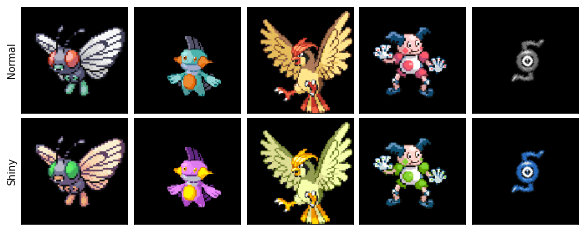

In [13]:
def print_examples(dataset, to_plot=5):
    """Print some examples from a batch"""
    
    for x_batch, y_batch in dataset.take(1):
        # prepare figure
        fig, axs = plt.subplots(2, to_plot, figsize=(2*to_plot, 2*2))
        
        # plot images
        for i, (img, shiny) in enumerate(zip(x_batch, y_batch)):
            axs[0,i].imshow((img.numpy()+1)/2)
            axs[1,i].imshow((shiny.numpy()+1)/2)

            if i >= to_plot-1:
                break
        
        # no axis ticks
        for ax in axs.flatten():
            ax.set(xticks=[], yticks=[])

        # set titles
        axs[0,0].set_ylabel('Normal')
        axs[1,0].set_ylabel('Shiny')

        fig.set_facecolor('white')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.show()
        plt.close()
        
print_examples(train_ds, 5)

# Build model
Dataset is 80x80 but we resize to 128x128

## UNET Generator model

In [14]:
# UNET (generator)
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)

    # add downsampling layer
    # if using batchnorm, then no bias needed
    g = layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=not(batchnorm))(layer_in)

    # optional batchnorm
    if batchnorm:
        # always operate in training mode, even when used during inference
        g = layers.BatchNormalization()(g, training=True)

    # All ReLUs in the encoder are leaky, with slope 0.2
    g = layers.LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)

    # add upsampling layer
    g = layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)

    # add batch norm always
    g = layers.BatchNormalization()(g, training=True)
    # optional dropout
    if dropout:
        g = layers.Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = layers.Concatenate()([g, skip_in])
    # ReLUs in the decoder are not leaky
    g = layers.ReLU()(g)
    return g

def define_generator(image_shape=(128,128,3)):
    """Modified structure for 128x128 input, simply removed one layer from each side"""
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)
    # image input
    in_image = layers.Input(shape=image_shape) # (batch_size, 128, 128, 3)

    # encoder model: C64-C128-C256-C512-C512-C512-C512
    # BatchNorm is not applied to the first C64 layer in the encoder
    e1 = encoder_block(in_image, 64, batchnorm=False) # (batch_size, 64, 64, 64)
    e2 = encoder_block(e1, 128)  # (batch_size, 32, 32, 128)
    e3 = encoder_block(e2, 256)  # (batch_size, 16, 16, 256)
    e4 = encoder_block(e3, 512)  # (batch_size,  8,  8, 512)
    e5 = encoder_block(e4, 512)  # (batch_size,  4,  4, 512)
    e6 = encoder_block(e5, 512)  # (batch_size,  2,  2, 512)

    # bottleneck, no batch norm, relu not leaky
    b = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
    b = layers.ReLU()(b) # (batch_size, 1, 1, 512)

    # decoder model: CD512-CD1024-CD1024-C1024-C512-C256-C128
    # N.B. only first 3 use dropout
    d1 = decoder_block(b,  e6, 512, dropout=True)   # (batch_size,   2,   2, 1024) # doubles filters due to concat
    d2 = decoder_block(d1, e5, 512, dropout=True)   # (batch_size,   4,   4, 1024)
    d3 = decoder_block(d2, e4, 512, dropout=True)   # (batch_size,   8,   8, 1024)
    d4 = decoder_block(d3, e3, 256, dropout=False)  # (batch_size,  16,  16,  512)
    d5 = decoder_block(d4, e2, 128, dropout=False)  # (batch_size,  32,  32,  256)
    d6 = decoder_block(d5, e1,  64, dropout=False)  # (batch_size,  64,  64,  128)

    # output (batch_size, 128, 128, 3)
    g = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    out_image = tf.keras.layers.Activation('tanh')(g)

    return Model(in_image, out_image)

# create the model
# model = define_generator()
# summarize the model
# model.summary()
# # plot the model
# plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
# #Let's try out the model to see what it predicts before training.
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Shiny', 'Predicted Shiny']

#   for i in range(len(display_list)):
#     img = display_list[i]
#     img = tf.squeeze(img) # (batch size=1, width, height, channels)
#     img = (img+1)/2
#     img = tf.keras.preprocessing.image.array_to_img(img)
    

#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(img)
#     plt.axis('off')
#   plt.show()

# def show_predictions(model, dataset=None, num=1):
#   if dataset:
#     for image, shiny in dataset.take(num):
#       pred_shiny = model(image, training=True)
#       display([image[0], shiny[0], pred_shiny[0]])
#   else:
#       pred_shiny = model(sample_image[tf.newaxis, ...], training=True)
#       display([sample_image, sample_shiny, pred_shiny])


# grab a sample image and mask to use throughout training
for image, shiny in train_ds.take(1):
  sample_image, sample_shiny = image[0], shiny[0]

# # show_predictions(generator)
# # show_predictions(generator, valid_ds)

The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want).

## PatchGAN Discriminator model

In [16]:
# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

# output layer 1x1 pixel with a 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)

# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)

# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


Running the example prints the size of the receptive field for each layer in the model from the output layer to the input layer.<br>
We can see that each 1×1 pixel in the output layer maps to a 70×70 receptive field in the input layer.

In [17]:
# PatchGAN (discriminator)
def define_discriminator(image_shape=(128,128,3)):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)
    # source image input
    in_src_image = layers.Input(shape=image_shape) # (batch_size, 128, 128, 3)
    # target image input
    in_target_image = layers.Input(shape=image_shape) # (batch_size, 128, 128, 3)
    # concatenate images channel-wise (batch_size, 128, 128, 6)
    merged = layers.Concatenate()([in_src_image, in_target_image])

    # Ck denote a Convolution-BatchNorm-ReLU layer with k filters
    # model: C64-C128-C256-C512
    # C64 - BatchNorm is not applied to the first C64 layer (batch_size, 64, 64, 64)
    d = layers.Conv2D(64,  (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = layers.LeakyReLU(alpha=0.2)(d) # All ReLUs are leaky, with slope 0.2
    # C128 (batch_size, 32, 32, 128)
    d = layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # C256 (batch_size, 16, 16, 256)
    d = layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # C512 (batch_size, 8, 8, 512)
    d = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # second last output layer - NB no strides (batch_size, 8, 8, 512)
    d = layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # patch output (batch_size, 8, 8, 1)
    d = layers.Conv2D(1,   (4,4), padding='same', kernel_initializer=init)(d)
    # patch_out = layers.Activation('sigmoid')(d)
    patch_out = d

    # define model 
    return Model([in_src_image, in_target_image], patch_out)

# create the model
# test_disc = define_discriminator()
# # summarize the model
# model.summary()
# # plot the model
# plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

We can see that the model output will be an activation map with the size 8x8 pixels or activations and a single channel, with each value in the map corresponding to a 70×70 pixel patch of the input 128x128 image.

## Combined GAN Model

In [18]:
def pix2pix_generator_loss(y_pred, y_target, out_img, target_img, LAMBDA=100):
    """
    loss=['binary_crossentropy', 'mae']
    loss_weights=[1, 100]
    The Pix2Pix generator uses a composite of Adversarial Loss (BCE) and L1 Loss (Pixel Distance Loss)

    The adversarial loss influences whether the generator model can output images
    that are plausible in the target domain.
    This is calculated from the output of the discriminator.
    
    The L1 loss regularizes the generator model to output images
    that are a plausible translation of the source image.
    This is calculated from the output of the generator.
    """   
    # binary cross entropy
    gan_loss = loss_object(y_target, y_pred)

    # Pixel distance loss (L1)
    l1_loss = tf.reduce_mean(tf.abs(target_img - out_img))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [19]:
class Pix2Pix(tf.keras.Model):
    """
    Inspired by this twitter post from the creator of keras
    https://twitter.com/fchollet/status/1250622989541838848/photo/1

    patch_size is the size of the output of the PatchGAN discriminator
    """
    def __init__(self, generator, discriminator, patch_size=8):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.patch_size = patch_size
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn):
        super(Pix2Pix, self).compile()
        self.g_optimizer = g_optimizer # Adam(lr=0.0002, beta_1=0.5)
        self.d_optimizer = d_optimizer # Adam(lr=0.0002, beta_1=0.5)
        self.g_loss_fn = g_loss_fn # loss=['binary_crossentropy', 'mae'], loss_weights=[1, 100]
        self.d_loss_fn = d_loss_fn # bce, loss_weights=[0.5]

    def call(self, data, training=False):
        # unpack data into normal (A) / shiny (B)
        # X_realA, X_realB = data
        gen_out = self.generator(data, training=training)
        dis_out = self.discriminator([gen_out, data], training=training)

        return dis_out, gen_out

    def show_predictions(self, input_img, target_img=False, wandb_title=False, show_plot=False):
        dis_out, gen_out = self.call(input_img)
        
        if isinstance(target_img, tf.Tensor):
            titles = ['Input Image', 'Target Image', 'Predicted Shiny', 'PatchGAN Output']
            display_list = [input_img, target_img, gen_out, dis_out]
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        else:
            titles = ['Input Image', 'Predicted Shiny', 'PatchGAN Output']
            display_list = [input_img, gen_out, dis_out]
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        for i, (ax, title, img) in enumerate(zip(axs, titles, display_list)):

            if title != 'PatchGAN Output':
                img = tf.squeeze(img)
                img = (img+1)/2
                img = tf.keras.preprocessing.image.array_to_img(img)
                ax.imshow(img)
            else:
                img = img[0,:,:,0].numpy()
                # img = -np.log(1 / img - 1) # undo sigmoid
                im = ax.imshow(img, vmin=0, vmax=1)
            
            # formatting
            ax.set_title(title)
            ax.axis('off')

        cb = fig.colorbar(im, ax=axs[-1], extend='both')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)

        if wandb_title:
            wandb.log({wandb_title: plt})

        if show_plot:
            plt.show()
        plt.close()

    def train_step(self, data):
        # unpack data into normal (A) / shiny (B)
        X_realA, X_realB = data
        batch_size = tf.shape(X_realA)[0]
        
        # generate labels for reals
        y_real = tf.ones((batch_size, self.patch_size, self.patch_size, 1))

        # generate a batch of fake samples
        X_fakeB = self.generator(X_realA, training=True)
        y_fake = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))

        # add random noise to the labels - important trick!
        y_real += 0.05 * tf.random.normal(tf.shape(y_real))
        y_fake += 0.05 * tf.random.normal(tf.shape(y_fake))
        
        # Reals and Fakes handled separately due to BatchNorm layers
        # The loss for the discriminator is weighted by 50% for each model update.
        # train discriminator on real samples
        with tf.GradientTape() as tape:
            predictions = self.discriminator([X_realA, X_realB], training=True)
            d_loss_real = self.d_loss_fn(y_real, predictions) * 0.5
        grads = tape.gradient(d_loss_real, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # train discriminator on fake samples
        with tf.GradientTape() as tape:
            predictions = self.discriminator([X_realA, X_fakeB], training=True)
            d_loss_fake = self.d_loss_fn(y_fake, predictions) * 0.5
        grads = tape.gradient(d_loss_fake, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # train the generator but do not update disciminator
        with tf.GradientTape() as tape:
            generated_images = self.generator(X_realA, training=True)
            predictions = self.discriminator([X_realA, generated_images], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.g_loss_fn(predictions, y_real, generated_images, X_realB)
        grads = tape.gradient(gen_total_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {
            'd_loss_real': d_loss_real,
            'd_loss_fake': d_loss_fake,
            'gen_total_loss': gen_total_loss,
            'gen_gan_loss': gen_gan_loss,
            'gen_l1_loss': gen_l1_loss
            }

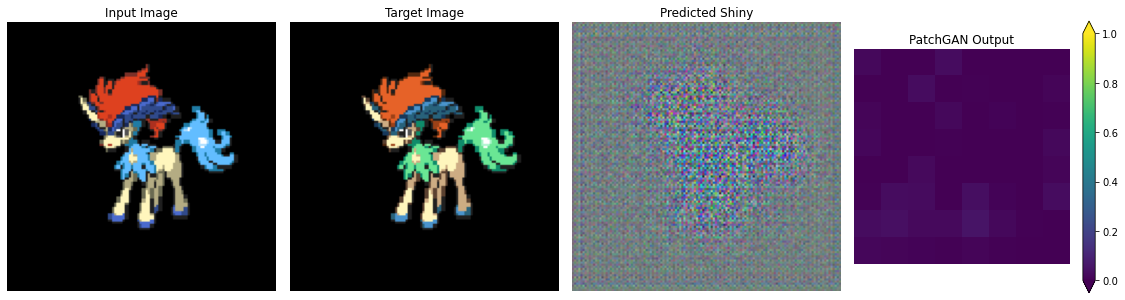

In [20]:
# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False) # both parts have an activbation at the end!
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator = define_generator()
discriminator = define_discriminator()
model = Pix2Pix(generator, discriminator, patch_size=PATCH_SIZE)

generator_loss = functools.partial(pix2pix_generator_loss, LAMBDA=LAMBDA)

model.compile(
    tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), # g_optimizer
    tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), # d_optimizer
    generator_loss, loss_object)

# check outputs
model.show_predictions(sample_image[tf.newaxis, ...], sample_shiny[tf.newaxis, ...], show_plot=True)

In [21]:
# observe improvement while training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.show_predictions(
            sample_image[tf.newaxis, ...],
            sample_shiny[tf.newaxis, ...],
            wandb_title=f'Training example')
        
        # plot validation example
        for x_batch, y_batch in valid_ds.take(1):
            val_img, val_shiny = x_batch[0], y_batch[0]
            model.show_predictions(
                val_img[tf.newaxis, ...],
                val_shiny[tf.newaxis, ...],
                wandb_title=f'Validation example')

    def on_train_begin(self, epoch, logs=None):
        model.show_predictions(
            sample_image[tf.newaxis, ...],
            sample_shiny[tf.newaxis, ...],
            wandb_title='Training Sample at t=0')

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    # validation_data=valid_ds,
    # verbose=0,
    callbacks=[
        DisplayCallback(),
        WandbCallback()
        ])

Epoch 1/25
573/573 [==============================] - 79s 126ms/step - d_loss_real: 0.3222 - d_loss_fake: 0.3197 - gen_total_loss: 12.9760 - gen_gan_loss: 1.6902 - gen_l1_loss: 0.1129
Epoch 2/25
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.3153 - d_loss_fake: 0.3020 - gen_total_loss: 9.7168 - gen_gan_loss: 1.5894 - gen_l1_loss: 0.0813
Epoch 3/25
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.3286 - d_loss_fake: 0.3103 - gen_total_loss: 9.0845 - gen_gan_loss: 1.4178 - gen_l1_loss: 0.0767
Epoch 4/25
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.3198 - d_loss_fake: 0.3011 - gen_total_loss: 8.9186 - gen_gan_loss: 1.4262 - gen_l1_loss: 0.0749
Epoch 5/25
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.3178 - d_loss_fake: 0.2996 - gen_total_loss: 8.8115 - gen_gan_loss: 1.3950 - gen_l1_loss: 0.0742
Epoch 6/25
573/573 [==============================] - 72s 125ms/step - d_loss_real: 

In [25]:
# continue training
history2 = model.fit(
    train_ds,
    epochs=history.epoch[-1]+75,
    initial_epoch=history.epoch[-1]+1,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        DisplayCallback(),
        WandbCallback()
        ])

Epoch 26/99
573/573 [==============================] - 71s 124ms/step - d_loss_real: 0.2837 - d_loss_fake: 0.2647 - gen_total_loss: 8.0799 - gen_gan_loss: 1.5348 - gen_l1_loss: 0.0655
Epoch 27/99
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.2773 - d_loss_fake: 0.2514 - gen_total_loss: 8.2017 - gen_gan_loss: 1.6139 - gen_l1_loss: 0.0659
Epoch 28/99
573/573 [==============================] - 71s 125ms/step - d_loss_real: 0.2889 - d_loss_fake: 0.2716 - gen_total_loss: 8.1490 - gen_gan_loss: 1.5429 - gen_l1_loss: 0.0661
Epoch 29/99
573/573 [==============================] - 71s 125ms/step - d_loss_real: 0.2788 - d_loss_fake: 0.2538 - gen_total_loss: 8.1971 - gen_gan_loss: 1.6494 - gen_l1_loss: 0.0655
Epoch 30/99
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.2686 - d_loss_fake: 0.2522 - gen_total_loss: 8.2211 - gen_gan_loss: 1.6730 - gen_l1_loss: 0.0655
Epoch 31/99
573/573 [==============================] - 71s 125ms/step - d_loss_r

In [153]:
# continue training even further
history3 = model.fit(
    train_ds,
    epochs=250,
    initial_epoch=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        DisplayCallback(),
        WandbCallback()
        ])

Epoch 101/250
573/573 [==============================] - 70s 123ms/step - d_loss_real: 0.1700 - d_loss_fake: 0.1586 - gen_total_loss: 9.1036 - gen_gan_loss: 3.0866 - gen_l1_loss: 0.0602
Epoch 102/250
573/573 [==============================] - 73s 127ms/step - d_loss_real: 0.1816 - d_loss_fake: 0.1714 - gen_total_loss: 8.9207 - gen_gan_loss: 2.9998 - gen_l1_loss: 0.0592
Epoch 103/250
573/573 [==============================] - 72s 125ms/step - d_loss_real: 0.1659 - d_loss_fake: 0.1508 - gen_total_loss: 8.9987 - gen_gan_loss: 3.0466 - gen_l1_loss: 0.0595
Epoch 104/250
573/573 [==============================] - 71s 124ms/step - d_loss_real: 0.1650 - d_loss_fake: 0.1549 - gen_total_loss: 9.0790 - gen_gan_loss: 3.1782 - gen_l1_loss: 0.0590
Epoch 105/250
573/573 [==============================] - 71s 124ms/step - d_loss_real: 0.1699 - d_loss_fake: 0.1620 - gen_total_loss: 8.9885 - gen_gan_loss: 3.0947 - gen_l1_loss: 0.0589
Epoch 106/250
573/573 [==============================] - 71s 124ms/ste

In [154]:
model.predict(train_ds.take(1))
model.save('models/2021-08-07-0050', save_format='tf')

INFO:tensorflow:Assets written to: models/2021-08-07-0050\assets


For the discriminator losses - The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.

# Exploring Results

## PatchGAN Outputs

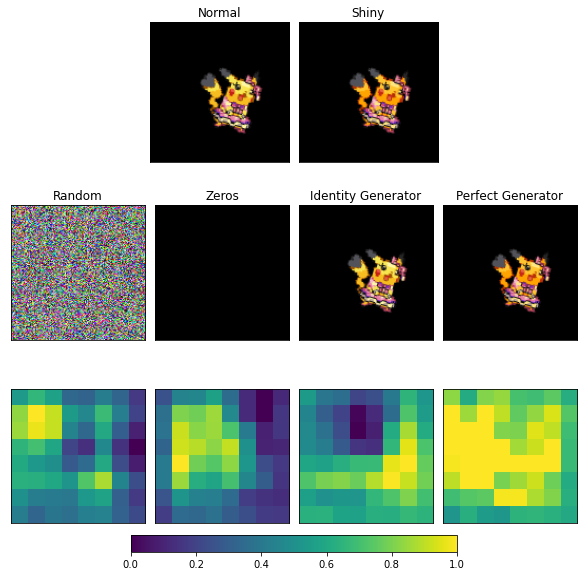

In [155]:
def plot_patches(normal, shiny):
    
    # Prepare the sub figures
    fig = plt.figure(constrained_layout=True, figsize=[8,8])
    gs0 = fig.add_gridspec(2,1, height_ratios=[1,2], hspace=0)

    gs00 = gs0[0].subgridspec(1,4)
    gs10 = gs0[1].subgridspec(2,4, hspace=0)

    # no ticks
    subplot_options = dict(xticks=[], yticks=[])

    # top 2
    ax1 = fig.add_subplot(gs00[1], title='Normal', **subplot_options)
    ax2 = fig.add_subplot(gs00[2], title='Shiny', **subplot_options)

    # Fake generator Ouputs
    ax3 = fig.add_subplot(gs10[0,0], title='Random', **subplot_options)
    ax4 = fig.add_subplot(gs10[0,1], title='Zeros', **subplot_options)
    ax5 = fig.add_subplot(gs10[0,2], title='Identity Generator', **subplot_options)
    ax6 = fig.add_subplot(gs10[0,3], title='Perfect Generator', **subplot_options)
    
    # PatchGan outputs
    ax7 = fig.add_subplot(gs10[1,0], **subplot_options)
    ax8 = fig.add_subplot(gs10[1,1], **subplot_options)
    ax9 = fig.add_subplot(gs10[1,2], **subplot_options)
    ax10 = fig.add_subplot(gs10[1,3], **subplot_options)
    
    # plot the images
    ax1.imshow((normal[0].numpy()+1)/2)
    ax2.imshow((shiny[0].numpy()+1)/2)
    
    # create random image
    rand_img = tf.random.uniform(normal.shape, -1, 1)
    rand_patch = model.discriminator([normal, rand_img])
    ax3.imshow((rand_img[0].numpy()+1)/2)
    ax7.imshow((rand_patch[0].numpy()+1)/2)
    
    # create random image
    zeros_img = -tf.ones_like(normal)
    zeros_patch = model.discriminator([normal, zeros_img])
    ax4.imshow((zeros_img[0].numpy()+1)/2)
    ax8.imshow((zeros_patch[0].numpy()+1)/2)
    
    # Identity generator
    ident_patch = model.discriminator([normal, normal])
    ax5.imshow((normal[0].numpy()+1)/2)
    ax9.imshow((ident_patch[0].numpy()+1)/2)
    
    # Perfect generator
    perfect_patch = model.discriminator([normal, shiny])
    ax6.imshow((shiny[0].numpy()+1)/2)
    im = ax10.imshow((perfect_patch[0].numpy()+1)/2, vmin=0, vmax=1)

    # styling
    cb = fig.colorbar(im, ax=[ax7,ax8,ax9,ax10], anchor=(0.5,0.5), orientation='horizontal', fraction=.1)
    cb.boundaries = [0,1]
    fig.set_facecolor('white')

    plt.show()
    plt.close()
    
for x_batch, y_batch in train_ds.take(1):
    plot_patches(x_batch[:1], y_batch[:1])

## Consistency accross games

Does the same pokemon get a similar shiny across different games?

In [156]:
def decode_image_crystal(file_path, image_shape):
    """images are rgba, convert to rgb by multiplying by the opacity"""
    # image is normalized to [0,1]
    file_path = tf.io.read_file(file_path)
    img = tf.io.decode_png(file_path)/255 # pics are rgba
    img = tf.cast(img, tf.float32)
    img = img*2 - 1 # bring to [-1,1]  (range of tanh)
    img = tf.image.resize(img, image_shape, method='nearest')
    return img

gold


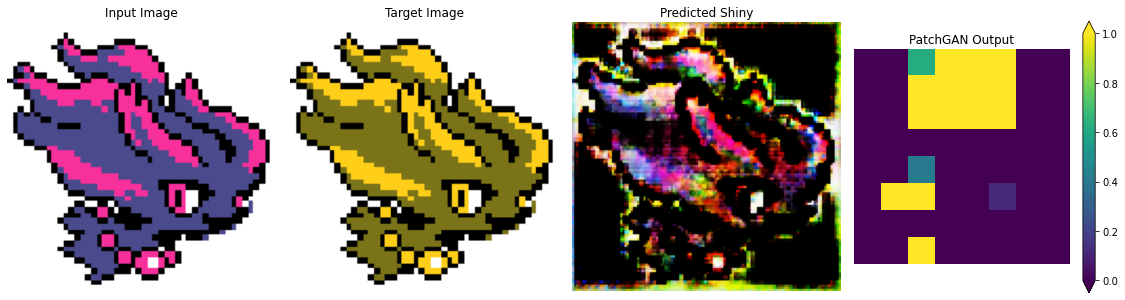

silver


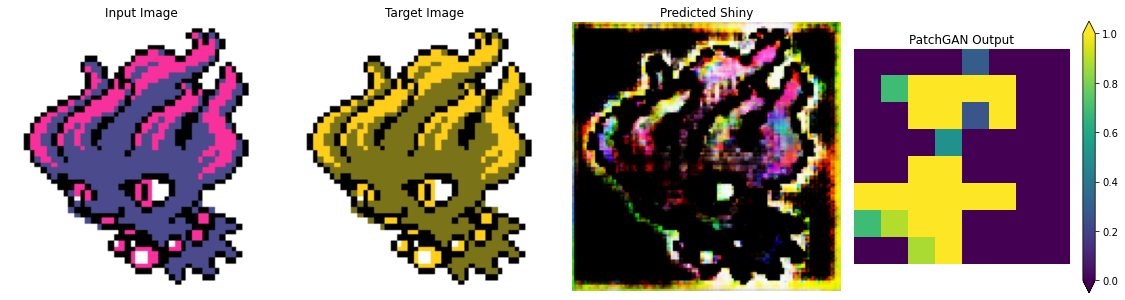

crystal


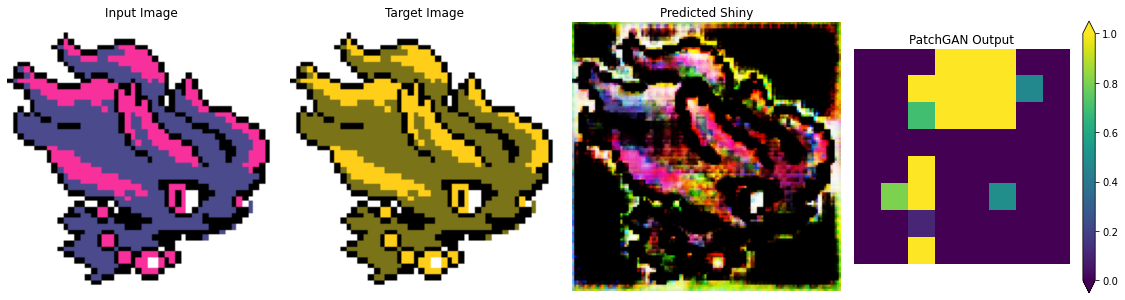

ruby-sapphire


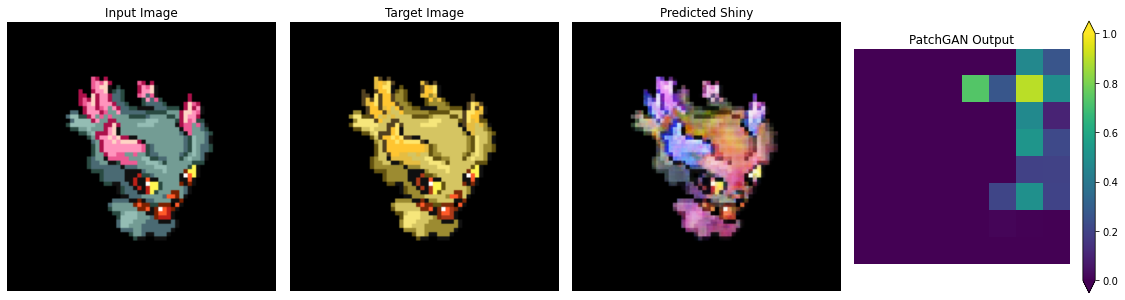

emerald


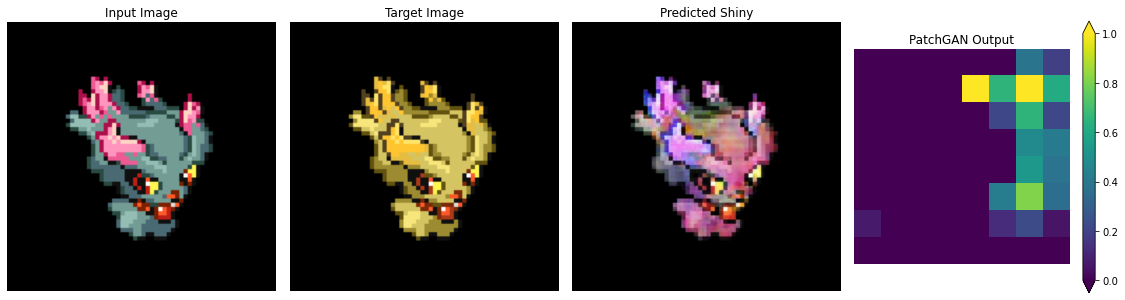

diamond-pearl


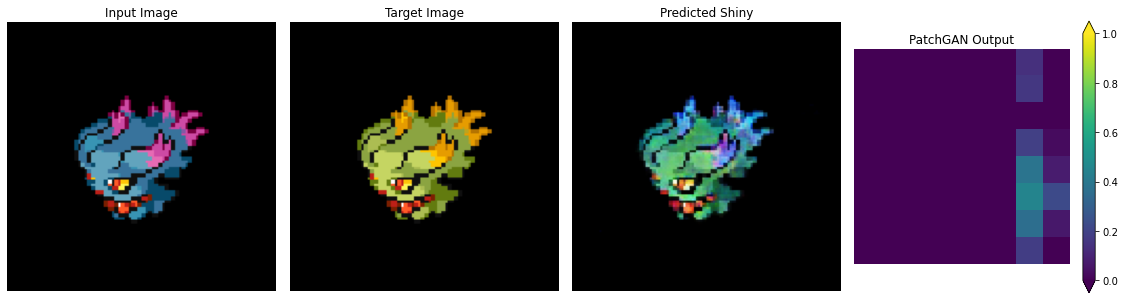

heartgold-soulsilver


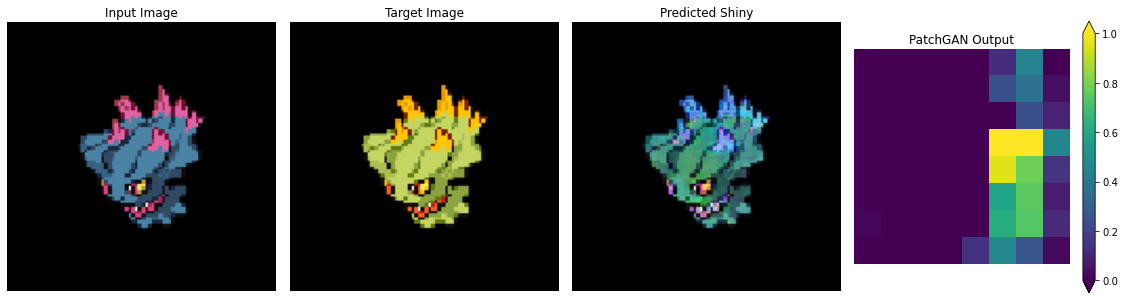

platinum


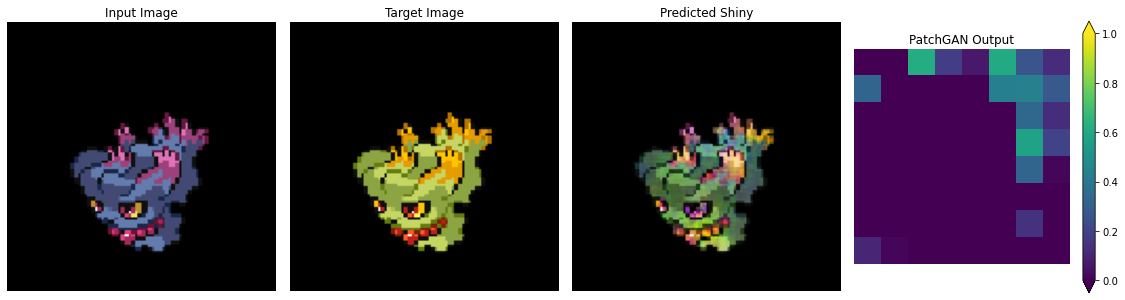

black-white


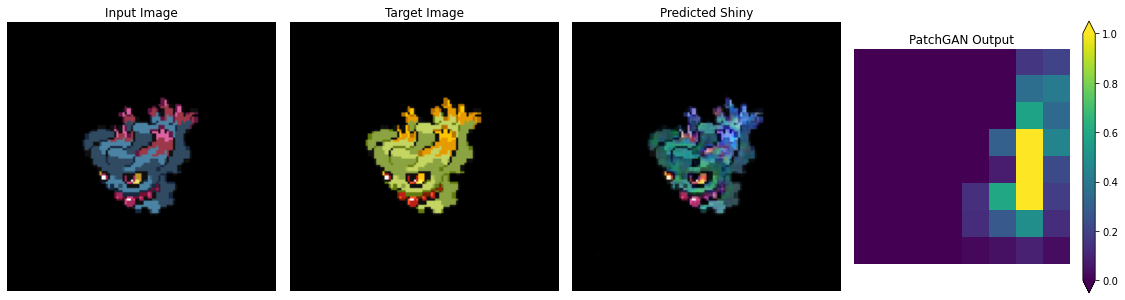

omegaruby-alphasapphire


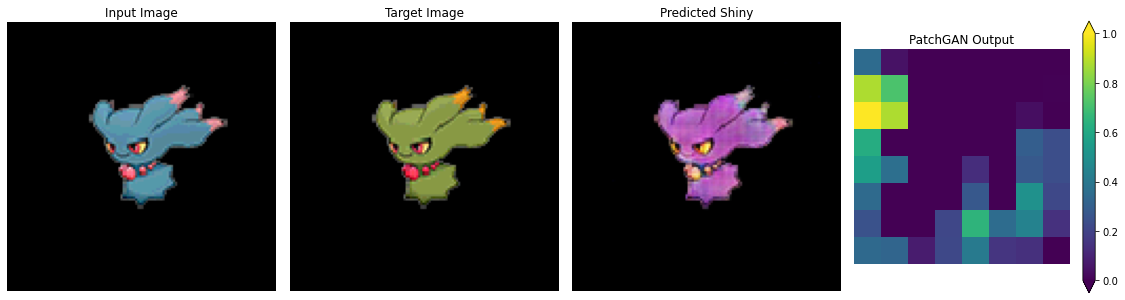

In [157]:
def test_all_versions(pokemon):
    """ Plot the predicted sprite for a pokemon across all games """
    pokemon = pokemon+'.png'

    games = [
        [decode_image_crystal, 'generation-ii', 'gold'],
        [decode_image_crystal, 'generation-ii', 'silver'],
        [decode_image_crystal, 'generation-ii', 'crystal'],
        [decode_image, 'generation-iii', 'ruby-sapphire'],
        [decode_image, 'generation-iii', 'firered-leafgreen'],
        [decode_image, 'generation-iii', 'emerald'],
        [decode_image, 'generation-iv', 'diamond-pearl'],
        [decode_image, 'generation-iv', 'heartgold-soulsilver'],
        [decode_image, 'generation-iv', 'platinum'],
        [decode_image, 'generation-v', 'black-white'],
        # [decode_image, 'generation-vi', 'x-y'],
        [decode_image, 'generation-vi', 'omegaruby-alphasapphire'],
        # [decode_image, 'generation-vii', 'ultra-sun-ultra-moon']
        ]

    for game in games:
        normal_path = f'data\\sprites\\pokemon\\versions\\{game[1]}\\{game[2]}\\{pokemon}'
        shiny_path  = f'data\\sprites\\pokemon\\versions\\{game[1]}\\{game[2]}\\shiny\\{pokemon}'
        if os.path.exists(normal_path) and os.path.exists(shiny_path):
            print(game[2])
            img = game[0](normal_path, image_shape=IMAGE_SIZE)
            img_shiny = game[0](shiny_path, image_shape=IMAGE_SIZE)
            model.show_predictions(img[tf.newaxis,...], img_shiny[tf.newaxis,...], show_plot=True)

pokemon = '200'
test_all_versions(pokemon)

## Bulk examples

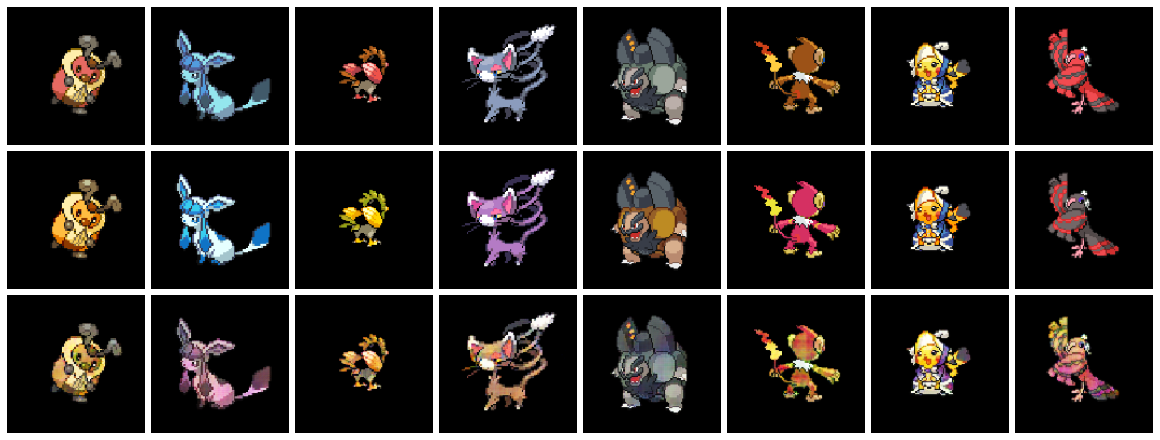

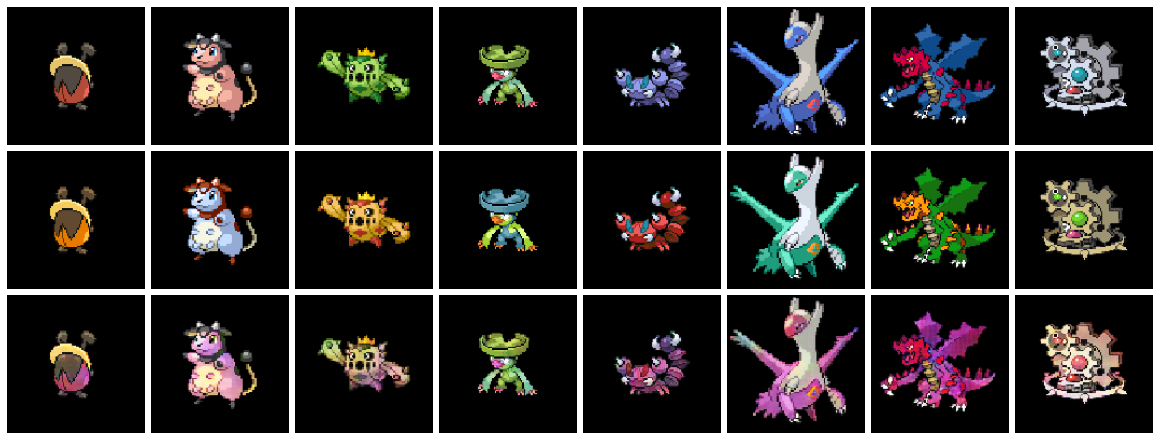

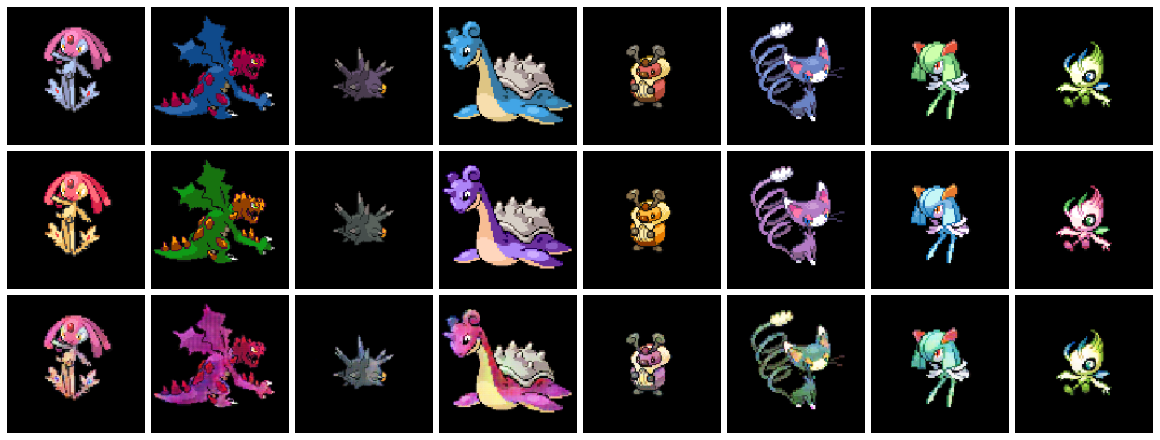

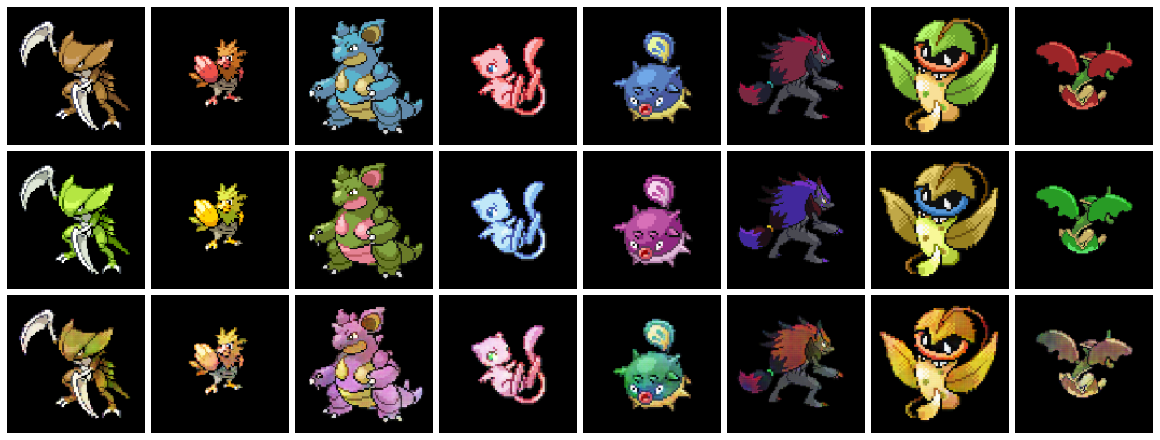

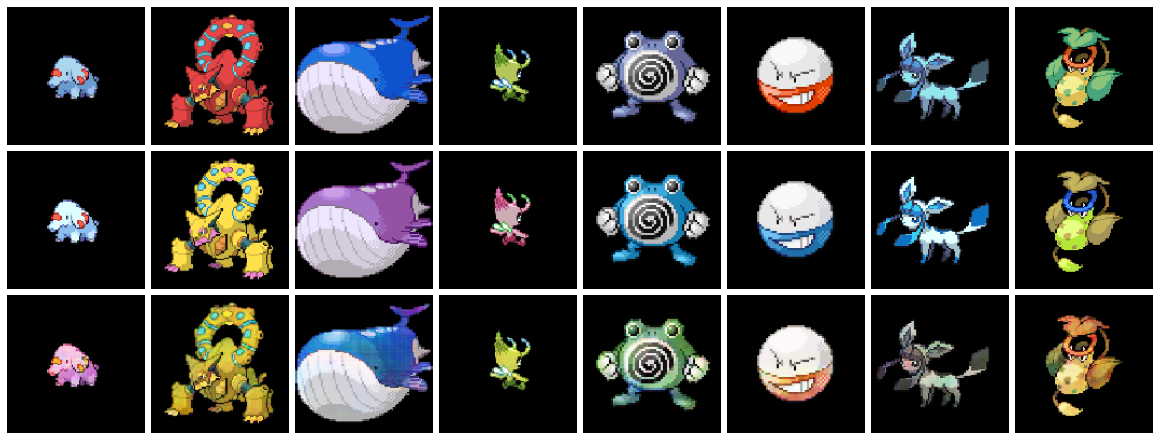

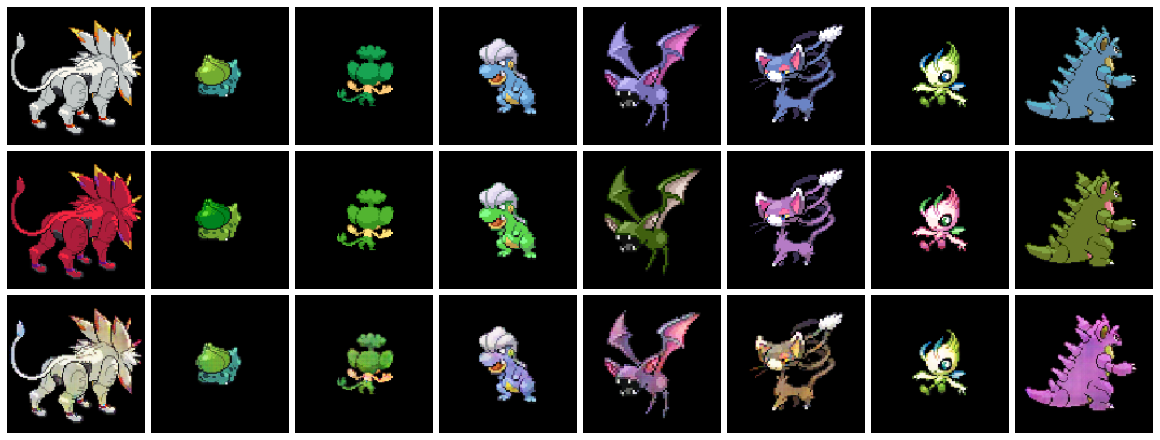

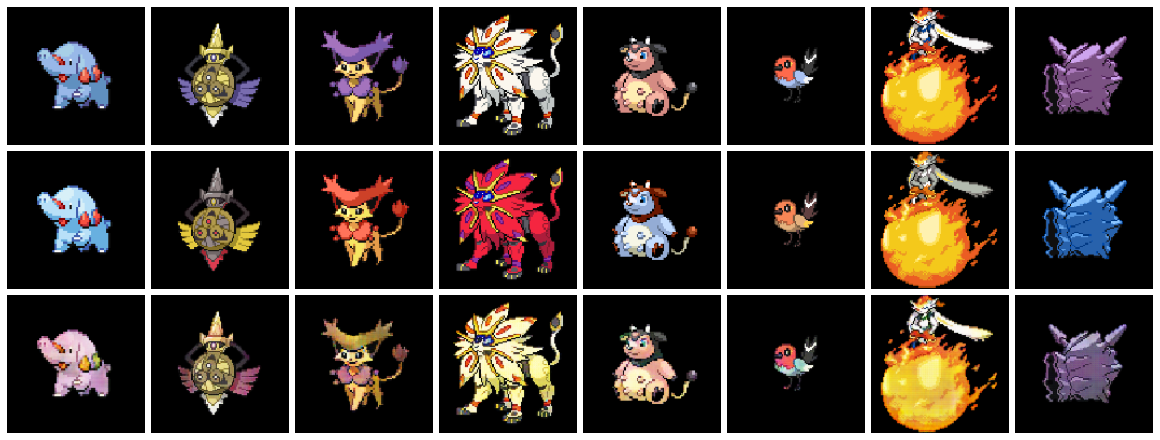

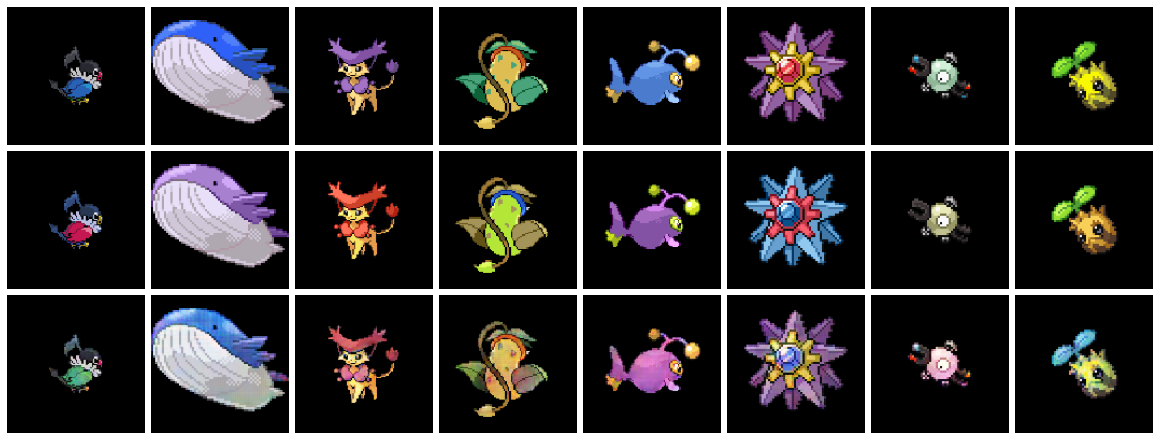

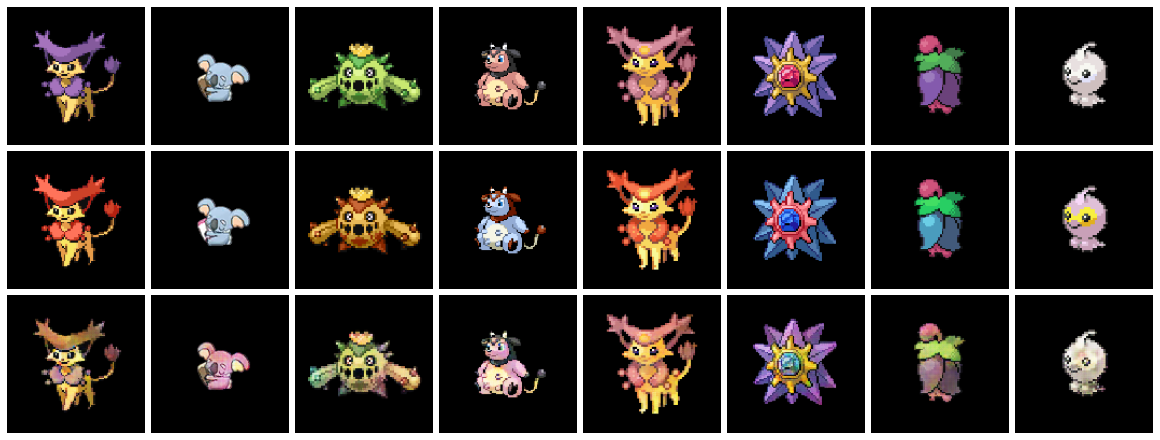

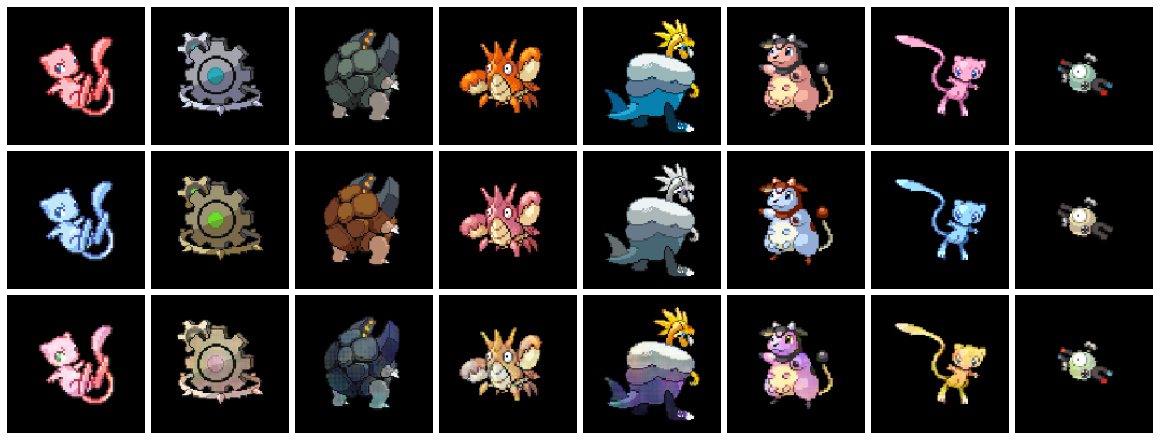

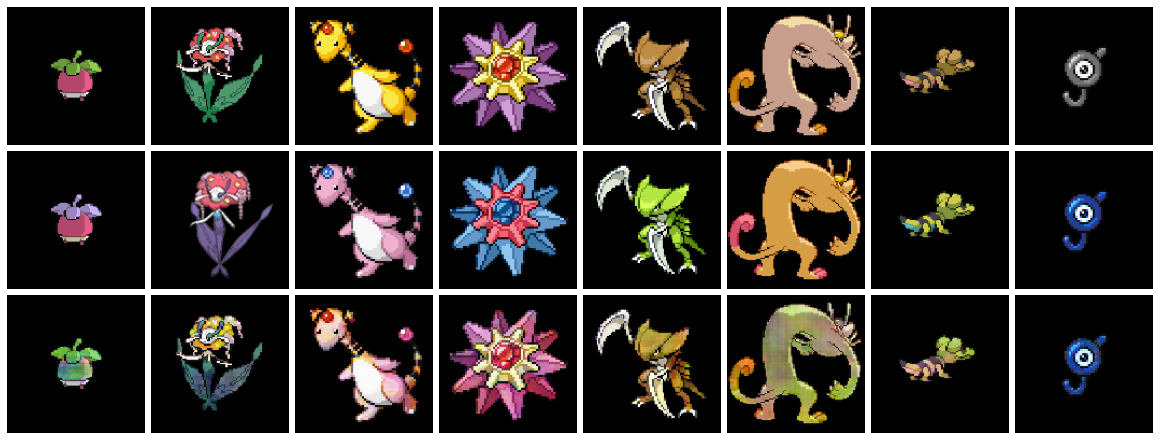

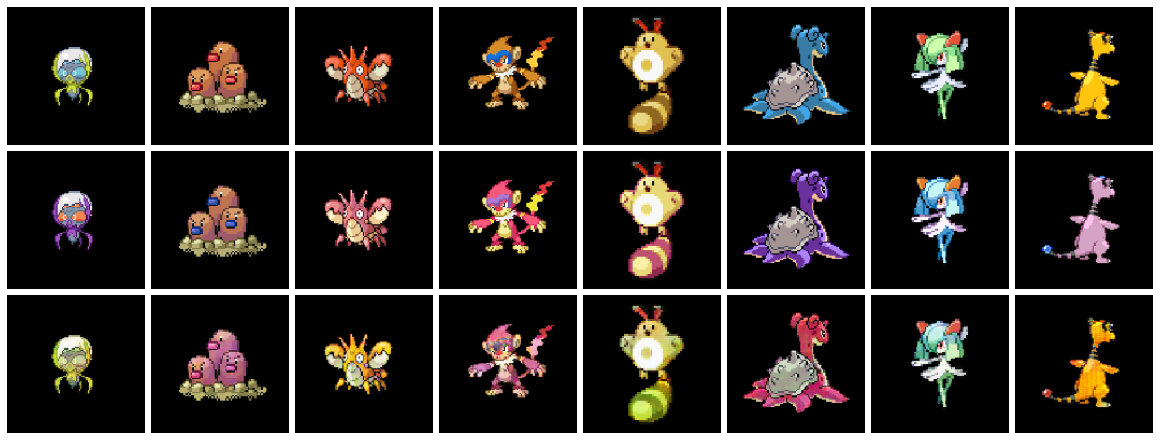

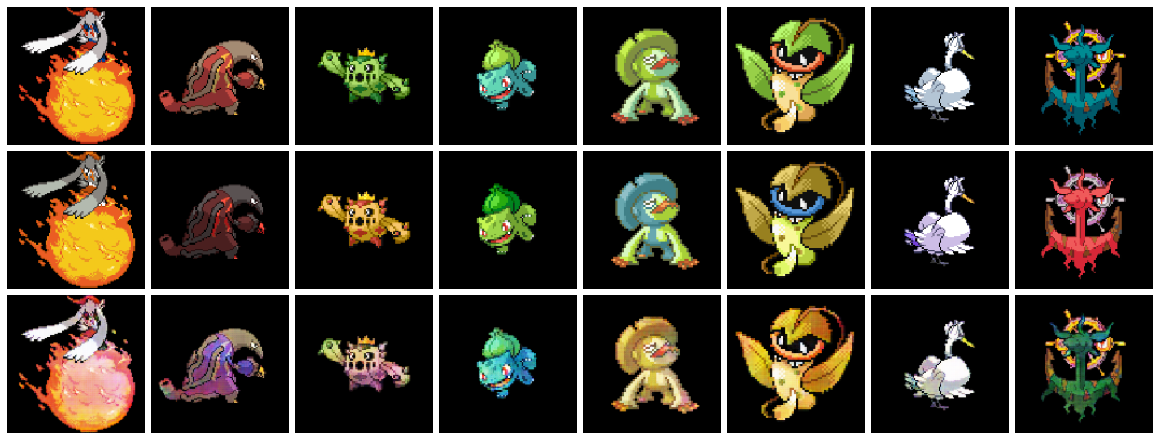

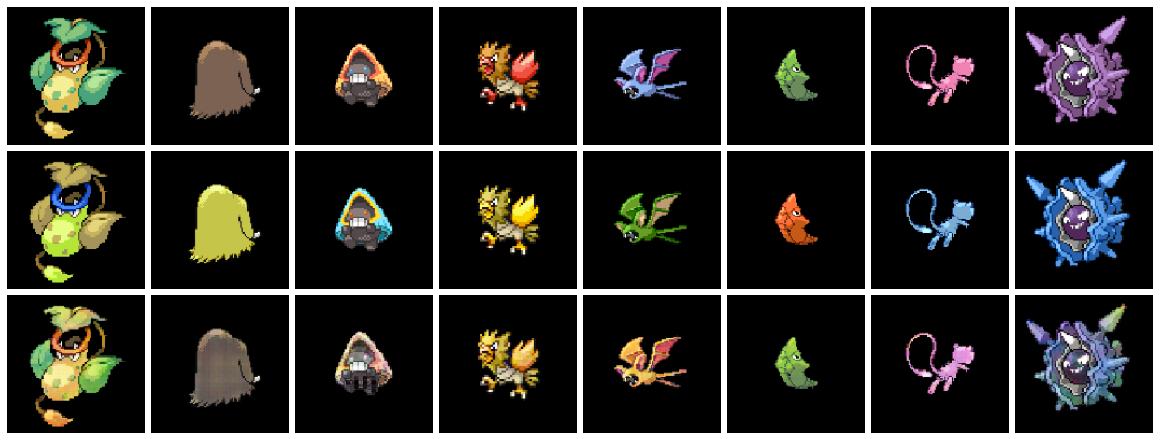

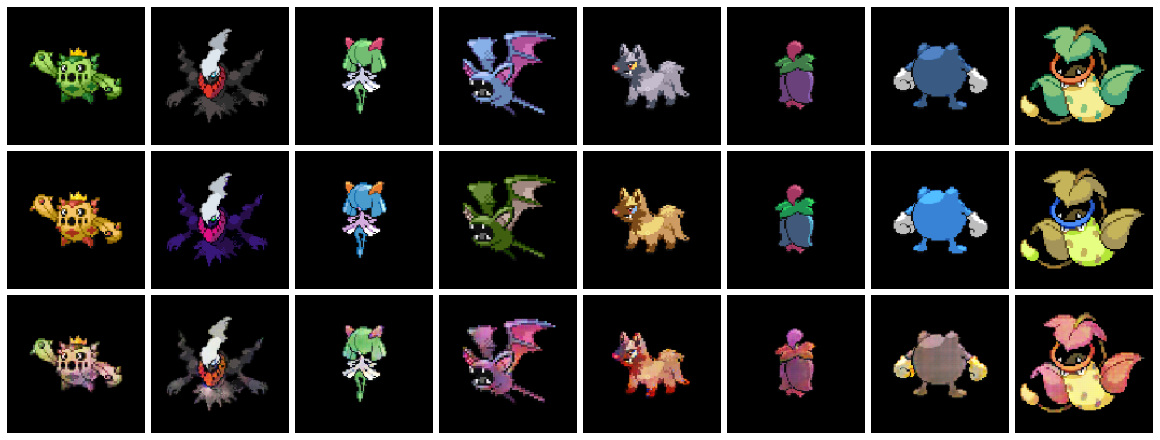

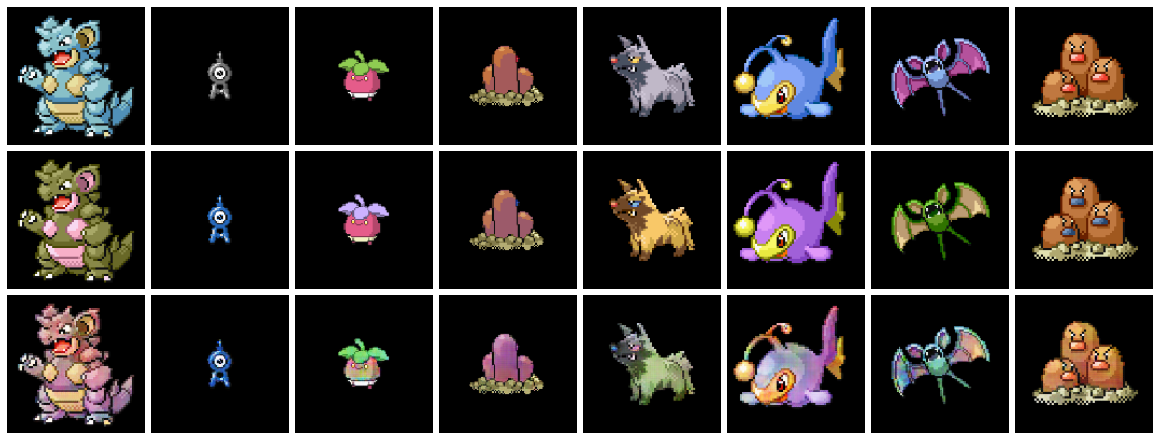

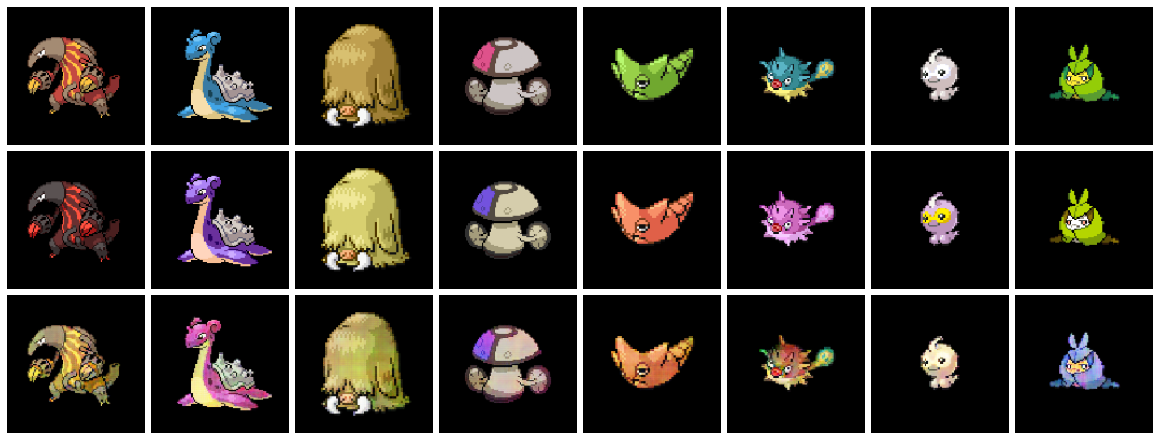

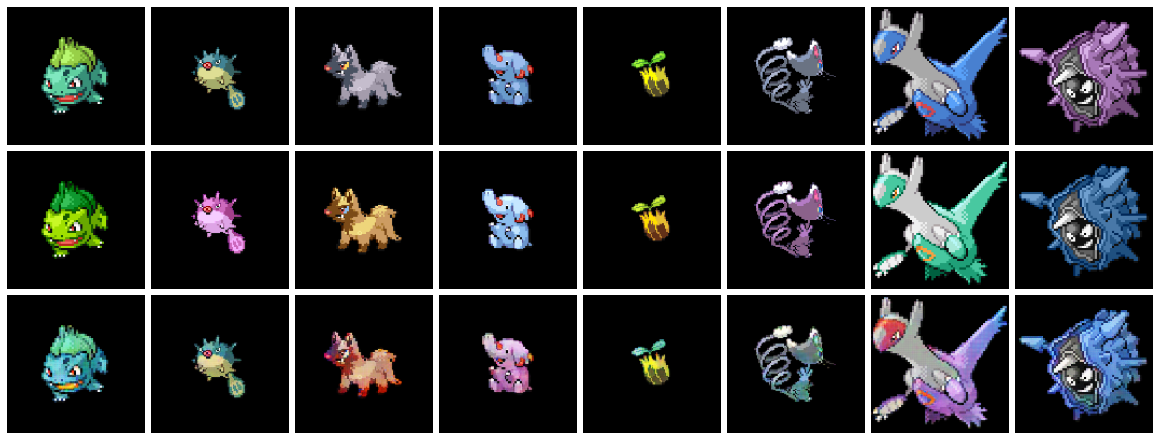

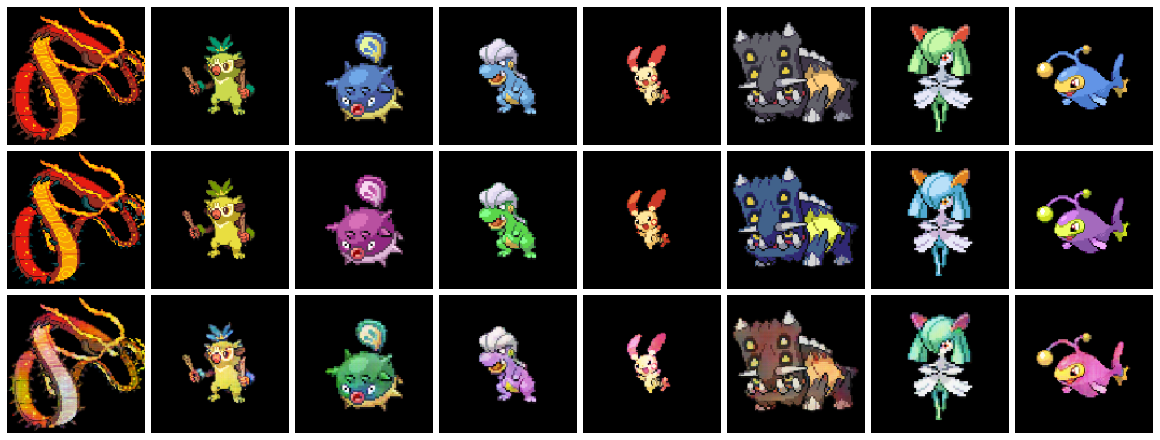

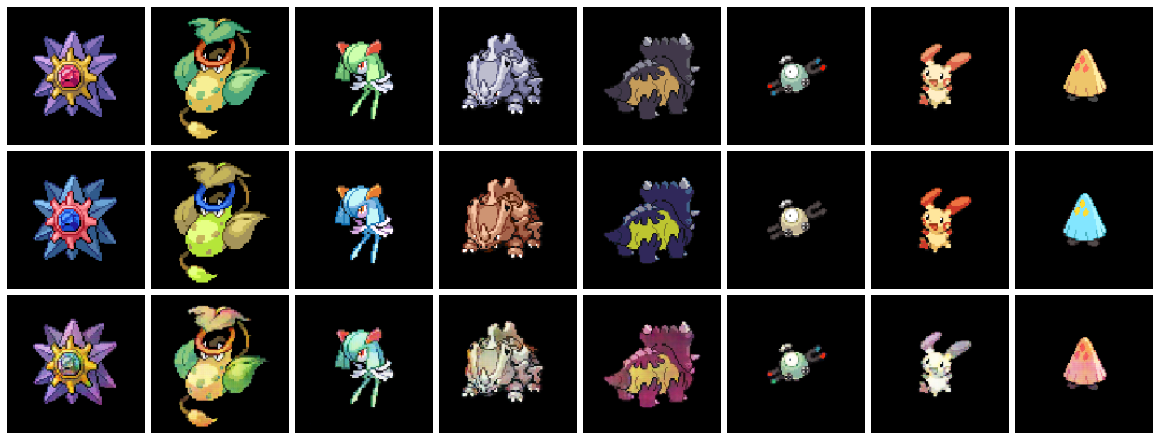

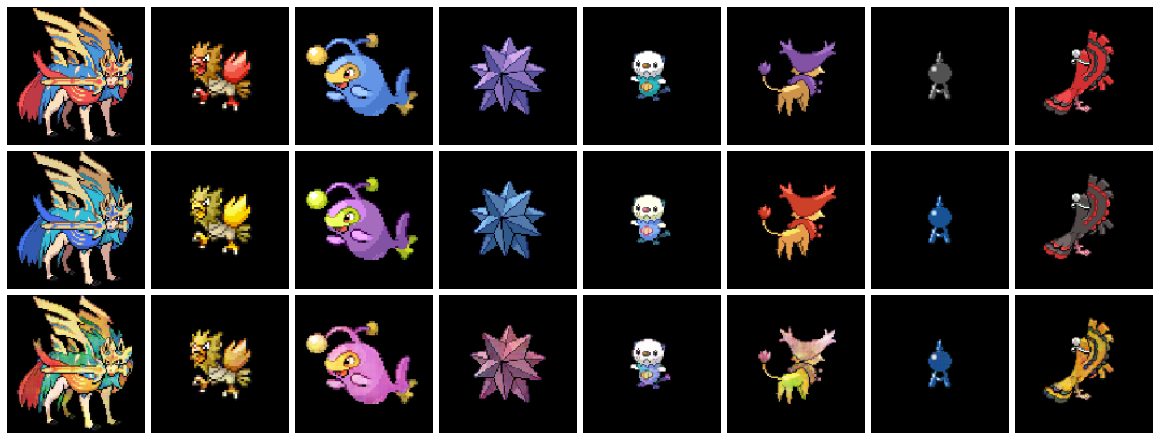

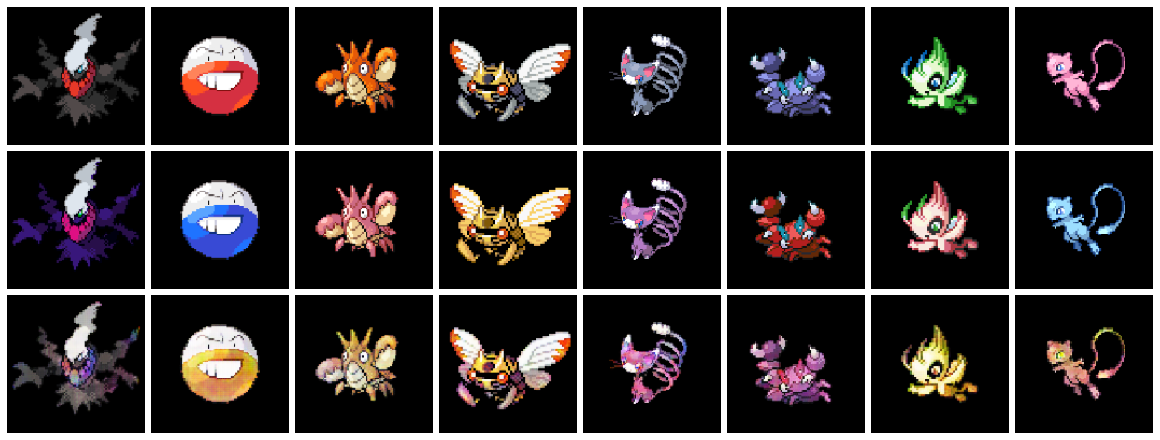

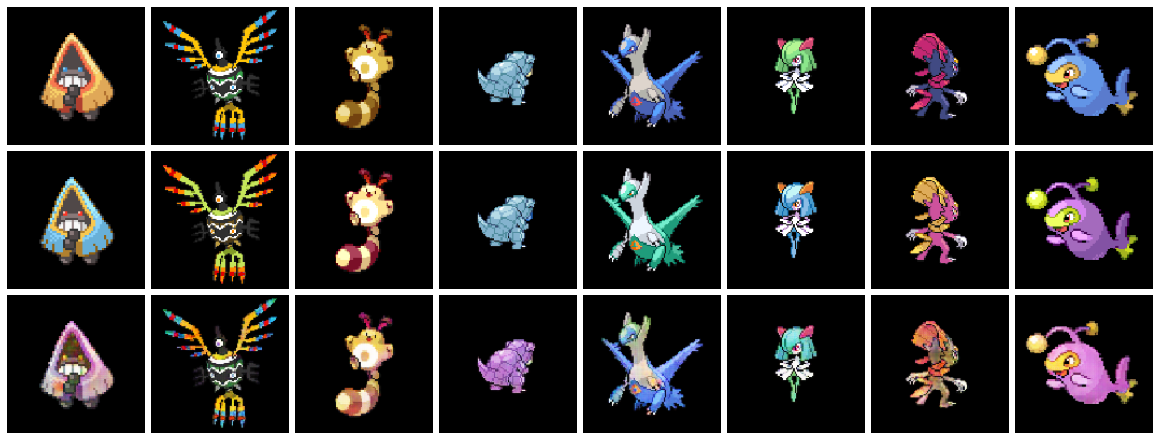

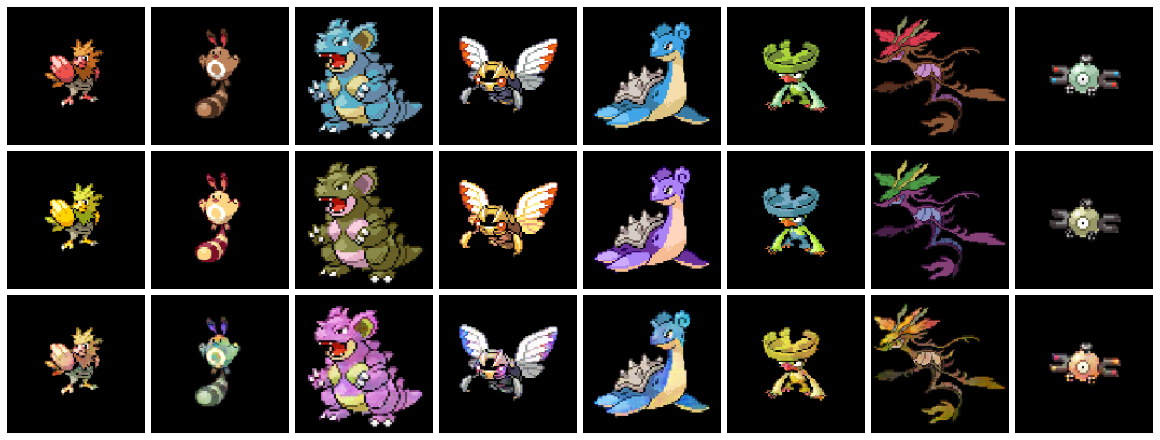

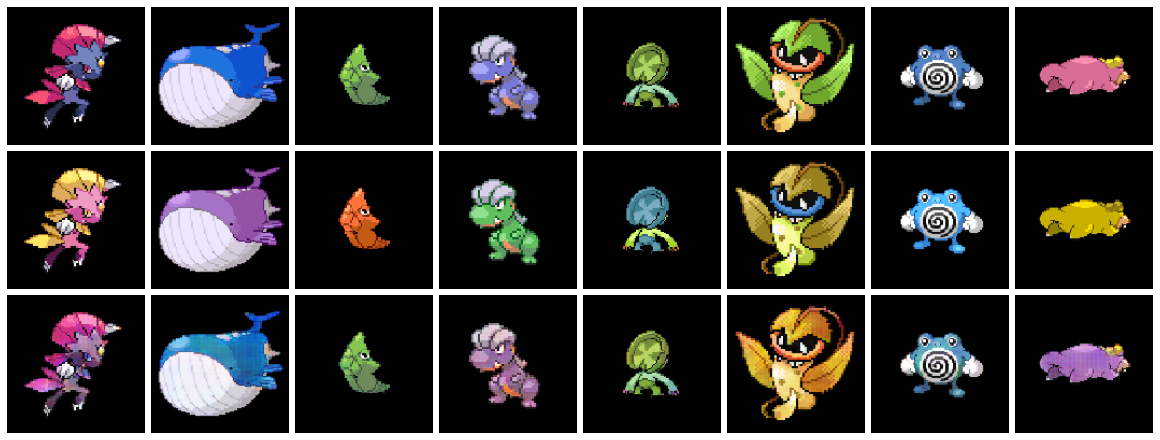

In [158]:
img_num = 0
for x_batch, y_batch in valid_ds.take(25):
    preds = (model(x_batch)[1].numpy()+1)/2
    
    x_batch = (x_batch.numpy()+1)/2
    y_batch = (y_batch.numpy()+1)/2
    
    fig = plt.Figure(figsize=[16,6], constrained_layout=True)
    gs = fig.add_gridspec(3,8)
    
    for i, imgs in enumerate(zip(x_batch, y_batch, preds)):
        for j, img in enumerate(imgs):
            ax = fig.add_subplot(gs[j,i])
            ax.imshow(img)
            ax.axis('off')
             
    fig.set_facecolor('white')
    
    fig.savefig(f'visualisations/No sigmoid 100 epochs/{img_num}')
    display(fig)
    img_num += 1

In [159]:
wandb.finish()